<a href="https://colab.research.google.com/github/brendarocha1/ser-347/blob/main/TRABALHO_FINAL__APRENDIZADO_PROFUNDO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Instituto Nacional de Pesquisas Espaciais
Disciplina: CAP - 421 - 3 Aprendizado Profundo
Docentes: Valdivino Santiago, Elcio Hideiti Shiguemori, Thales Sehn Körting
Discente: Brenda Oliveira Rocha

## Trabalho Final
* Rede ConvLSTM e segmentação de séries temporais
de imagens Sentinel-2 para o
monitoramento de áreas inundadas


## **1.** Instalando as bibliotecas

In [ ]:
!pip install rasterio
!pip install keras-tuner
import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.warp import Resampling
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras_tuner import HyperModel, RandomSearch
from collections import defaultdict
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization, Conv2D, Dropout, MaxPooling2D, UpSampling2D, Conv3D
from tensorflow.keras.metrics import Precision, Recall, MeanIoU
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, jaccard_score, accuracy_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 95.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.9 MB/s eta 0:00:00


## **2.** Lendo e extraindo a série temporal de imagens ópticas para o ano de 2024 (janeiro - outubro)

In [ ]:
!gdown --id 1y5x7YEBpanrf2cv5kaCDy9upZSpE8tKb  #link para a pasta contendo a série temporal de imagens ópticas (Sentinel2)

# Extrair arquivos ZIP
zip_path = '/content/2024_TODOS_OS_RECORTES.zip'
output_dir = "dados_opticos"


if not os.path.exists(output_dir):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(output_dir)
        print(f"Conteúdo extraído para: {output_dir}")

# Caminho da pasta específica extraída
specific_dir = os.path.join(output_dir, "2024_TODOS_OS_RECORTES")
if not os.path.exists(specific_dir):
    raise FileNotFoundError(f"A pasta esperada não foi encontrada: {specific_dir}")

# Estrutura para armazenar dados por mês e banda (sem carregar imagens ainda)
images_by_month = defaultdict(lambda: {"B02": None, "B03": None, "B04": None, "B8A": None})
dates_by_month = defaultdict(lambda: {"B02": None, "B03": None, "B04": None, "B8A": None})

# Mapear os arquivos TIF
for root, _, files in os.walk(specific_dir):
    for file in files:
        if file.endswith(".tif") and "RECORTADO" in file:
            parts = file.split('_')
            if len(parts) >= 4:
                full_date = parts[2]
                date = full_date.split('T')[0]
                month = date[:6]
                band = parts[3]
                images_by_month[month][band] = os.path.join(root, file)
                dates_by_month[month][band] = date

meses = {
    "01": "Janeiro",
    "02": "Fevereiro",
    "03": "Março",
    "04": "Abril",
    "05": "Maio",
    "06": "Junho",
    "07": "Julho",
    "08": "Agosto",
    "09": "Setembro",
    "10": "Outubro",
    "11": "Novembro",
    "12": "Dezembro"
}

# Ordenar os meses em ordem crescente
sorted_months = sorted(images_by_month.keys())

# Exibir as informações sobre os dados da série temporal
for month in sorted_months:
    month_name = meses[month[4:6]]  # Pega o nome do mês a partir do código
    print(f"Mês: {month} ({month_name})")
    for band, filepath in images_by_month[month].items():
        if filepath:
            date = dates_by_month[month][band]
            with rasterio.open(filepath) as src:
                dimensions = src.shape  # Pegar as dimensões da imagem (altura, largura)
            print(f"  Banda {band}: Dimensão {dimensions}; Data da imagem: {date}")


# Inicializar matriz para dados temporais
dados_temporais = []

# Processar todos os meses disponíveis
for month, bands in images_by_month.items():
    month_data = []
    for band, filepath in bands.items():
        if filepath:
            with rasterio.open(filepath) as src:
                band_data = src.read(1)  # Carregar uma única banda
                month_data.append(band_data)
    if month_data:
        dados_temporais.append(np.stack(month_data, axis=0))  # Empilhar as bandas como canais

# Converter para um array numpy com formato: (tempo, bandas, altura, largura)
dados_temporais = np.stack(dados_temporais, axis=0)
print(f"Formato do array 'dados_temporais': {dados_temporais.shape}")

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1y5x7YEBpanrf2cv5kaCDy9upZSpE8tKb
From (redirected): https://drive.google.com/uc?id=1y5x7YEBpanrf2cv5kaCDy9upZSpE8tKb&confirm=t&uuid=a105d8c8-77ae-4b4d-a276-e0e5c1a0eb43
To: /content/2024_TODOS_OS_RECORTES.zip
100% 503M/503M [00:04<00:00, 107MB/s]
Conteúdo extraído para: dados_opticos
Mês: 202401 (Janeiro)
  Banda B02: Dimensão (3085, 2319); Data da imagem: 20240114
  Banda B03: Dimensão (3085, 2319); Data da imagem: 20240114
  Banda B04: Dimensão (3085, 2319); Data da imagem: 20240114
  Banda B8A: Dimensão (3085, 2319); Data da imagem: 20240114
Mês: 202402 (Fevereiro)
  Banda B02: Dimensão (3085, 2319); Data da imagem: 20240203
  Banda B03: Dimensão (3085, 2319); Data da imagem: 20240203
  Banda B04: Dimen

## **2.1** Visualização das bandas referentes ao mês de maio

Processando bandas para o mês de maio (202405)


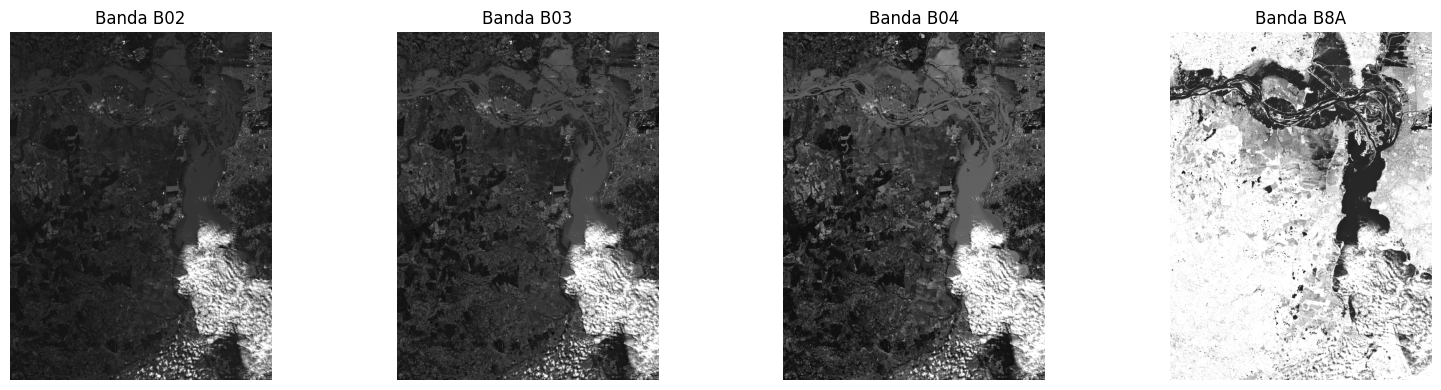

In [ ]:
# Processar mês de interesse diretamente (apenas um mês na memória por vez)
month_of_interest = "202405"

if month_of_interest in images_by_month:
    print(f"Processando bandas para o mês de maio ({month_of_interest})")

    # Loop pelas bandas do mês
    data_bands = {}
    for band, filepath in images_by_month[month_of_interest].items():
        if filepath:
            with rasterio.open(filepath) as src:
                data_bands[band] = src.read(1)  # Carregar apenas uma banda

    # Normalizar os dados para o intervalo [0, 1] se necessário
    data_bands_normalized = {band: data / np.max(data) for band, data in data_bands.items()}

    # Aumentar o brilho (aplicar multiplicação para aumentar a intensidade)
    brightness_factor = 4.5  # Fator para aumentar o brilho (quanto maior, mais brilho)
    data_bands_bright = {band: np.clip(data * brightness_factor, 0, 1) for band, data in data_bands_normalized.items()}

    # Plotar bandas
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    for i, (band, data) in enumerate(data_bands_bright.items()):
        axs[i].imshow(data, cmap="gray")
        axs[i].set_title(f"Banda {band}")
        axs[i].axis("off")
    plt.tight_layout()
    plt.show()

## **3.** Lendo e extraindo as máscaras de referência (água = 1; não-água = 0)

In [ ]:
!gdown --id 1pg1FPoxlOqRllil1v99_9kBZmsn0qGBI  # Link para a pasta contendo as máscara de referência

# Caminho do arquivo ZIP
mascara_path = 'mascaras.zip'

# Tamanho desejado
output_shape = (3085, 2319)

# Lista para armazenar os dados redimensionados
resized_rasters = []

# Abrir o arquivo ZIP e processar os arquivos
with zipfile.ZipFile(mascara_path, 'r') as zip_ref:
    # Listar os 10 primeiros arquivos .tif
    tif_files = [f for f in zip_ref.namelist() if f.endswith('.tif')][:10]

    for tif_file in tif_files:
        # Abrir o arquivo TIFF do ZIP como um buffer
        with zip_ref.open(tif_file) as file:
            with rasterio.open(file) as src:
                # Ler os dados e redimensionar
                data = src.read(
                    out_shape=(1, output_shape[0], output_shape[1]),  # Redimensionar
                    resampling=Resampling.bilinear  # Usar interpolação bilinear
                )
                # Remover a dimensão do canal
                resized_rasters.append(data[0])

# Converter a lista em um array NumPy com forma (10, 3085, 2319)
mask_list = np.stack(resized_rasters)

print("Array final shape:", mask_list.shape)


/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1pg1FPoxlOqRllil1v99_9kBZmsn0qGBI
From (redirected): https://drive.google.com/uc?id=1pg1FPoxlOqRllil1v99_9kBZmsn0qGBI&confirm=t&uuid=d3039e44-d520-4dd9-b2f0-6bad960c378a
To: /content/mascaras.zip
100% 3.58M/3.58M [00:00<00:00, 246MB/s]
Array final shape: (10, 3085, 2319)


## **3.1** Visualização das máscaras de referência binárias para todos os meses

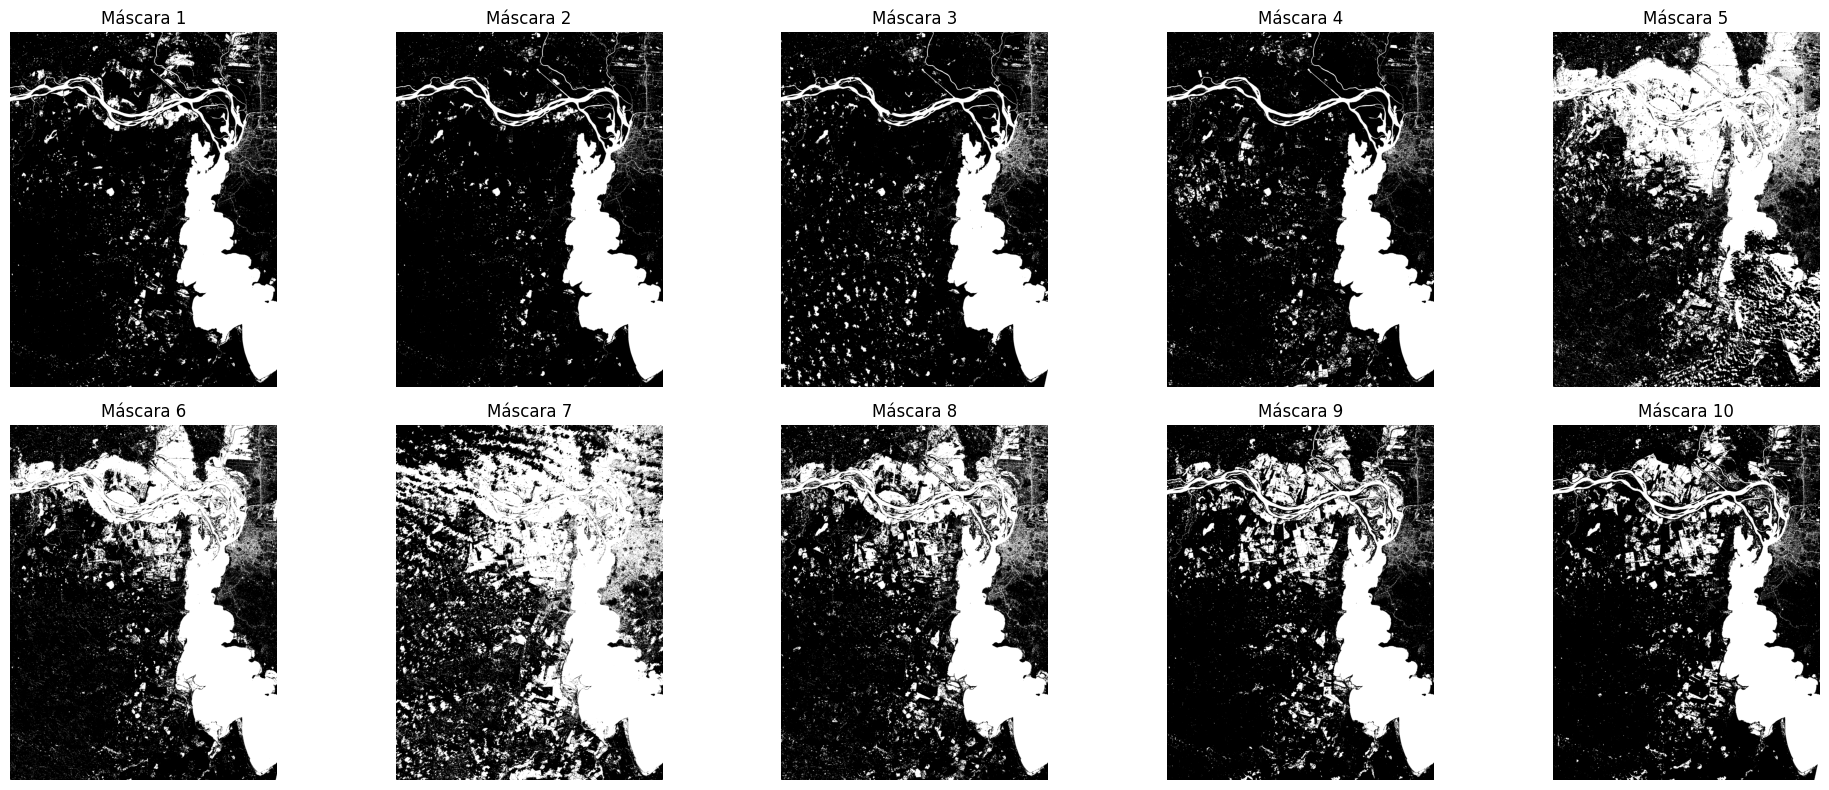

[0 1]


In [ ]:
# Número de máscaras para exibir
num_masks = 10

# Criar a figura e os subplots
fig, axes = plt.subplots(2, 5, figsize=(20, 8))  # 2 linhas x 5 colunas

# Iterar sobre as máscaras e exibir nos subplots
for i, ax in enumerate(axes.flat):
    if i < num_masks:
        ax.imshow(mask_list[i], cmap='gray')  # Exibir a máscara em escala de cinza
        ax.set_title(f'Máscara {i+1}')
        ax.axis('off')  # Remover os eixos

# Ajustar o layout
plt.tight_layout()
plt.show()

mask_list = np.array(mask_list).astype("int64")
print(np.unique(mask_list))

## **4.** Normalização dos dados ópticos

In [ ]:
def normalize_temporal_data(dados_temporais):
    """
    Normaliza os dados temporais no intervalo [0, 1], banda a banda.

    Args:
        dados_temporais (np.ndarray): Dados no formato (tempo, canais, altura, largura).

    Returns:
        np.ndarray: Dados normalizados no mesmo formato de entrada.
    """
    tempo, canais, altura, largura = dados_temporais.shape
    dados_temporais_normalizados = np.zeros_like(dados_temporais, dtype=np.float32)

    for c in range(canais):
        banda = dados_temporais[:, c, :, :]
        min_val = banda.min()
        max_val = banda.max()
        dados_temporais_normalizados[:, c, :, :] = (banda - min_val) / (max_val - min_val)

    return dados_temporais_normalizados

# Normalizar os dados temporais
dados_temporais_normalizados = normalize_temporal_data(dados_temporais)

print(f"Dados temporais normalizados: {dados_temporais_normalizados.shape}")


Dados temporais normalizados: (10, 4, 3085, 2319)


In [ ]:
print(f"Dimensão dos dados temporais normalizados: {dados_temporais_normalizados.shape}")
print(f"Dimensão da lista de máscaras: {mask_list.shape}")


Dimensão dos dados temporais normalizados: (10, 4, 3085, 2319)
Dimensão da lista de máscaras: (10, 3085, 2319)


## **5.** Divisão dos dados em patches 128x128

In [ ]:
def dividir_em_patches_alinhados(dados, patch_size=(128, 128)):
    """
    Divide os dados em patches de forma alinhada espacialmente.
    Funciona tanto para dados temporais 4D (n_temporal, n_bandas, altura, largura)
    quanto para máscaras 3D (n_temporal, altura, largura).

    Args:
        dados (np.ndarray): Dados de entrada no formato 3D ou 4D.
        patch_size (tuple): Tamanho do patch (altura, largura).

    Returns:
        np.ndarray: Patches divididos.
    """
    import numpy as np

    if len(dados.shape) == 3:  # Máscaras ou dados 3D
        n_temporal, altura, largura = dados.shape
        dados_temporais = False
    elif len(dados.shape) == 4:  # Dados temporais 4D com múltiplas bandas
        n_temporal, n_bandas, altura, largura = dados.shape
        dados_temporais = True
    else:
        raise ValueError(f"Dados não possuem formato esperado. Dimensões recebidas: {dados.shape}")

    patches = []

    # Loop para dividir em patches alinhados
    for t in range(n_temporal):
        for i in range(0, altura, patch_size[0]):
            for j in range(0, largura, patch_size[1]):
                if not dados_temporais:  # Máscaras 3D
                    patch = dados[t, i:i+patch_size[0], j:j+patch_size[1]]
                    # Preencher bordas caso o patch não seja completo
                    patch_preenchido = np.zeros((patch_size[0], patch_size[1]))
                    patch_preenchido[:patch.shape[0], :patch.shape[1]] = patch
                else:  # Dados temporais 4D
                    patch = dados[t, :, i:i+patch_size[0], j:j+patch_size[1]]
                    # Preencher bordas caso o patch não seja completo
                    patch_preenchido = np.zeros((n_bandas, patch_size[0], patch_size[1]))
                    patch_preenchido[:, :patch.shape[1], :patch.shape[2]] = patch

                patches.append(patch_preenchido)

    # Converter lista de patches para array NumPy
    patches = np.array(patches)
    return patches


## **5.1** Divisão dos patches dos dados ópticos

In [ ]:
# Cortar as raster
patches_raster = dividir_em_patches_alinhados(dados_temporais_normalizados)

# Exibindo o formato final
print(f"Shape patches dos dados: {patches_raster.shape}")

Shape patches dos dados: (4750, 4, 128, 128)


Remoção de variáveis para a limpeza da memória

In [ ]:
del dados_temporais_normalizados
del dados_temporais
del images_by_month
del dates_by_month

## **5.2** Divisão dos patches das máscaras de referência

In [ ]:
# Cortar as mascaras
mask_list = np.array(mask_list)
# (10, 1, 3085, 2319)

# Máscaras
patches_mask = dividir_em_patches_alinhados(mask_list)
print("Shape patches dos mask:", patches_mask.shape)

Shape patches dos mask: (4750, 128, 128)


## **5.3** Visualização de alguns patches e suas máscaras de referência

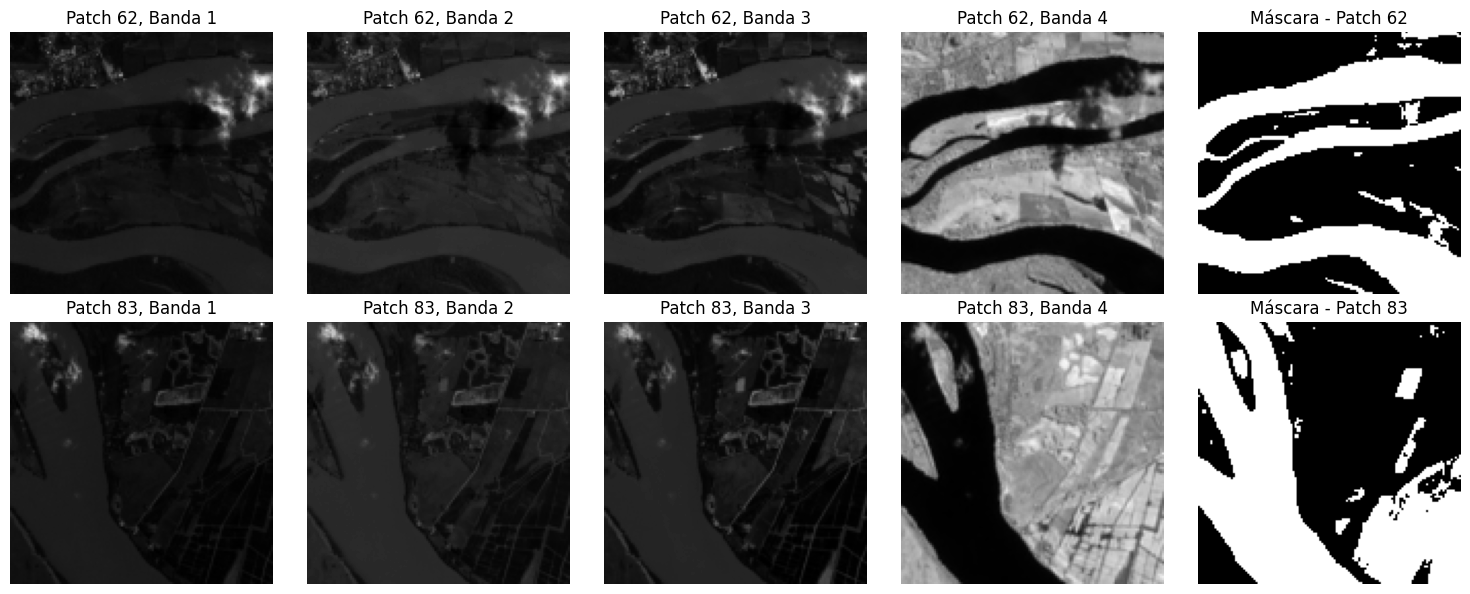

In [ ]:
# Definir os índices dos patches a serem visualizados
indices = [61, 82]

# Criar uma figura para visualizar os patches
fig, axes = plt.subplots(len(indices), 5, figsize=(15, 6))

for i, idx in enumerate(indices):
    # Acessar os dados e máscaras correspondentes
    patch_raster = patches_raster[idx]  # Formato (4, 128, 128)
    patch_mask = patches_mask[idx]  # Formato (128, 128) ou (10, 128, 128, 1)

    # Garantir que a máscara tenha a forma correta
    if patch_mask.ndim > 2:  # Caso tenha dimensões extras
        patch_mask = patch_mask[0, :, :, 0]  # Selecionar o primeiro canal

    # Visualizar as 4 bandas do patch
    for band in range(4):
        axes[i, band].imshow(patch_raster[band], cmap='gray')
        axes[i, band].set_title(f'Patch {idx + 1}, Banda {band + 1}')
        axes[i, band].axis('off')

    # Visualizar a máscara correspondente
    axes[i, 4].imshow(patch_mask, cmap='gray')
    axes[i, 4].set_title(f'Máscara - Patch {idx + 1}')
    axes[i, 4].axis('off')

# Ajustar o layout e exibir
plt.tight_layout()
plt.show()



## **6.** Incluindo a dimensão temporal na estrutura das variáveis

##**6.1** Incluindo a dimensão temporal nos patches das máscaras de referência

In [ ]:
# Reformular máscaras para incluir a dimensão temporal
patches_mask = patches_mask.reshape(475, 10, 128, 128, 1)  # Adiciona um canal
print("Novo formato das máscaras:", patches_mask.shape)

Novo formato das máscaras: (475, 10, 128, 128, 1)


Remoção de variáveis para a limpeza da memória

In [ ]:
del mask_list

## **6.2** Incluindo a dimensão temporal nos patches dos dados ópticos

In [ ]:
# Definindo o número de meses e o tamanho dos patches
n_meses = 10
patch_size = 128
n_bandas = 4

# Calculando o número total de patches
total_patches = patches_raster.shape[0]

# Verificando quantas amostras de 10 meses podemos gerar
patches_por_amostra = n_meses  # Cada amostra tem 10 meses

# O número total de amostras será o total de patches dividido pelo número de meses
n_samples = total_patches // n_meses  # Divide os patches em sequências de 10 meses

# Garantir que estamos usando o número correto de patches
patches_raster_ajustado = patches_raster[:n_samples * n_meses]

# Reorganizando os dados para o formato desejado
dados_reformulados = np.zeros((n_samples, n_meses, patch_size, patch_size, n_bandas))

# Reorganizando os patches para criar sequências temporais
for i in range(n_samples):
    for j in range(n_meses):
        # Cada sequência de 10 meses será organizada em dados reformulados
        # Transpor as dimensões para garantir que o formato seja (128, 128, 4)
        dados_reformulados[i, j] = np.transpose(patches_raster_ajustado[i * n_meses + j], (1, 2, 0))

# Exibindo a forma final dos dados
print(f"Formato final para ConvLSTM: {dados_reformulados.shape}")  # (475, 10, 128, 128, 4)



Formato final para ConvLSTM: (475, 10, 128, 128, 4)


Estrutura final dos dados

In [ ]:
# Exibindo a forma final dos dados
print(f"Formato final para ConvLSTM da série temporal de imagens: {dados_reformulados.shape}")  # (475, 10, 128, 128, 4)
print("Formato final das máscaras de referência:", patches_mask.shape)

Formato final para ConvLSTM da série temporal de imagens: (475, 10, 128, 128, 4)
Formato final das máscaras de referência: (475, 10, 128, 128, 1)


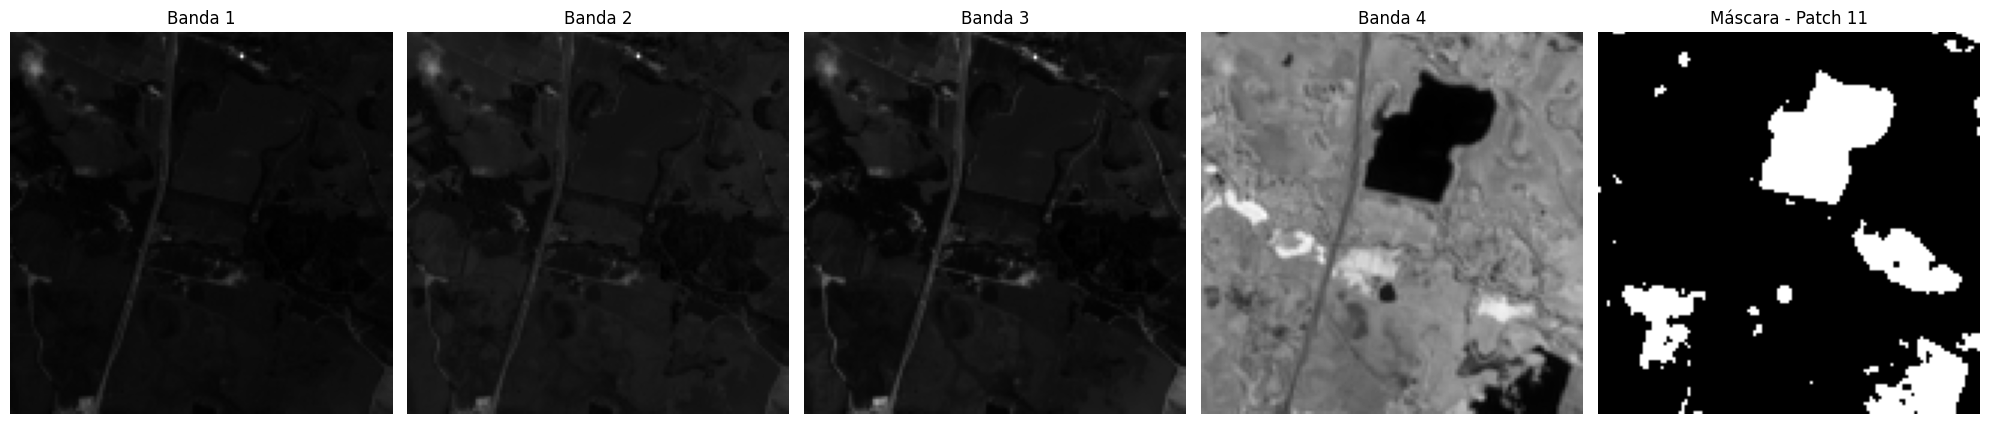

In [ ]:
# Selecionar o patch número 11 (index 10, pois a indexação começa em 0)
patch_35 = dados_reformulados[35]  # (10, 128, 128, 4)

# Selecionar o primeiro timestep (ou outro, se necessário)
timestep = 0  # Primeiro timestep

# Acessar a máscara correspondente ao patch 11
patch_mask_35 = patches_mask[35]  # Acessando a máscara correspondente ao patch 11

# Plotar as 4 bandas para o patch número 11
fig, axes = plt.subplots(1, 5, figsize=(20, 6))

# Plotar as 4 bandas do primeiro timestep
for band in range(4):
    axes[band].imshow(patch_11[timestep, :, :, band], cmap='gray')
    axes[band].set_title(f'Banda {band + 1}')
    axes[band].axis('off')

# Plotar a máscara correspondente (agora acessando corretamente a máscara)
axes[4].imshow(patch_mask_11[timestep, :, :], cmap='gray')  # A máscara não tem a dimensão de banda, é 2D
axes[4].set_title(f'Máscara - Patch 11')
axes[4].axis('off')

# Ajuste para o layout
plt.tight_layout()
plt.show()



## **7.** Dividindo os dados em treinamento, validação e teste

In [ ]:
X = dados_reformulados
y = patches_mask

# Dividindo os dados em treino, validação e teste sem embaralhar
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)  # 70% treino, 30% para validação e teste
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)  # 15% validação, 15% teste

# Exibindo as dimensões das variáveis
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")


X_train: (332, 10, 128, 128, 4), y_train: (332, 10, 128, 128, 1)
X_val: (71, 10, 128, 128, 4), y_val: (71, 10, 128, 128, 1)
X_test: (72, 10, 128, 128, 4), y_test: (72, 10, 128, 128, 1)


## **8.** Criação do modelo ConvLSTM

In [ ]:
def model_builder(hp):
    model = Sequential()

    # Camadas do modelo (conforme já mostrado)
    model.add(ConvLSTM2D(
        filters=hp.Int('filters_1', min_value=32, max_value=128, step=32),
        kernel_size=(hp.Int('kernel_size_1', min_value=3, max_value=5, step=1), hp.Int('kernel_size_1', min_value=3, max_value=5, step=1)),
        padding='same', return_sequences=True,
        input_shape=(10, 128, 128, 4)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)))

    # Mais camadas do modelo
    model.add(ConvLSTM2D(
        filters=hp.Int('filters_2', min_value=64, max_value=256, step=64),
        kernel_size=(hp.Int('kernel_size_2', min_value=3, max_value=5, step=1), hp.Int('kernel_size_2', min_value=3, max_value=5, step=1)),
        padding='same', return_sequences=True
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)))

    # Camada final
    model.add(Conv3D(filters=1, kernel_size=(1, 3, 3), activation='sigmoid', padding='same'))

    # Compilação do modelo
    model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy', Precision()])
    return model

## **8.1** Aplicando o Keras-Tuner para a busca dos melhores hiperparâmetros

In [ ]:
# Configurar EarlyStopping e ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

# Keras-Tuner
# Configuração do RandomSearch
tuner = RandomSearch(
    model_builder,
    objective='val_loss',
    max_trials=10,
    directory='keras_tuner_dir',
    project_name='conv_lstm_model'
)

# Realizando a busca dos melhores hiperparâmetros
tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=2, callbacks=[early_stopping, model_checkpoint])

# Recuperando o melhor modelo
best_model = tuner.get_best_models(num_models=1)[0]


# Salvar o melhor modelo treinado
best_model.save("melhor_modelo_keras_tuner.keras")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
32                |32                |filters_1
4                 |4                 |kernel_size_1
0.2               |0.2               |dropout_1
192               |192               |filters_2
3                 |3                 |kernel_size_2
0.2               |0.2               |dropout_2

Epoch 1/10


KeyboardInterrupt: 

## **8.1** Recuperando e salvando o melhor modelo salvo pelo Keras-Tuner

In [ ]:
# Recuperar o melhor modelo já avaliado
#best_model = tuner.get_best_models(num_models=1)[0]

# Salvar o melhor modelo
#best_model.save("melhor_modelo_keras_tuner_interrompido.keras")

#print("Melhor modelo salvo com sucesso!")


## **8.2** Carregando o melhor modelo salvo pelo Keras-Tuner

In [ ]:
!gdown --id 1w6jEdyfjIb1ejKsf83bBGF1cfuATobJ0 #link para o arquivo contendo o melhor modelo salvo

# Carregar o melhor modelo salvo
best_model = load_model("/content/melhor_modelo_keras_tuner.keras")
# Verificar a nova configuração do modelo
best_model.summary()

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1w6jEdyfjIb1ejKsf83bBGF1cfuATobJ0
To: /content/melhor_modelo_keras_tuner.keras
100% 4.05M/4.05M [00:00<00:00, 282MB/s]


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 26 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)             │ (None, 10, 128, 128, 96)    │         345,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 10, 128, 128, 96)    │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 128, 128, 96)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)           │ (None, 10, 128, 128, 64)    │         655,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 10, 128, 128, 64)    │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10, 128, 128, 64)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d (Conv3D)                      │ (None, 10, 128, 128, 1)     │             577 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,007,813 (11.47 MB)

 Trainable params: 1,002,497 (3.82 MB)

 Non-trainable params: 320 (1.25 KB)

 Optimizer params: 2,004,996 (7.65 MB)

## **9.** Treinando a rede ConvLSTM a partir do melhor modelo selecionado pelo Keras-Tuner

In [ ]:
# Configurar o EarlyStopping para monitorar a perda de validação
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Treinar o modelo com os dados de treinamento e validação
history = best_model.fit(
    X_train, y_train,  # Dados de entrada e rótulos de treinamento
    epochs=15,         # Número de épocas
    batch_size=8,     # Tamanho do lote
    validation_data=(X_val, y_val),  # Dados de validação
    callbacks=[early_stopping]  # Usar o early stopping para monitorar a perda de validação
)

# Mostrar um resumo do treinamento
print("Treinamento concluído.")

# Salvar o modelo treinado
best_model.save('modelo_treinado.h5')  # Salva o modelo em um arquivo .h5
print("Modelo salvo com sucesso!")

Epoch 1/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 113s 3s/step - accuracy: 0.7595 - loss: 0.5167 - precision: 0.6206 - val_accuracy: 0.8169 - val_loss: 0.4248 - val_precision: 0.6504
Epoch 2/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.8626 - loss: 0.3785 - precision: 0.8423 - val_accuracy: 0.8201 - val_loss: 0.4476 - val_precision: 0.8810
Epoch 3/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.8595 - loss: 0.3759 - precision: 0.8353 - val_accuracy: 0.8303 - val_loss: 0.4028 - val_precision: 0.9001
Epoch 4/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.8535 - loss: 0.3752 - precision: 0.8603 - val_accuracy: 0.8395 - val_loss: 0.3690 - val_precision: 0.9127
Epoch 5/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.8521 - loss: 0.3727 - precision: 0.8543 - val_accuracy: 0.8450 - val_loss: 0.3638 - val_precision: 0.9081
Epoch 6/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.8422 - loss: 0.3852 - precision: 0.8532 - val_accuracy: 0.7925 - val_loss: 0.483

Treinamento concluído.
Modelo salvo com sucesso!


## **9.1** Plotando as curvas de acurácia e perda do treinamento

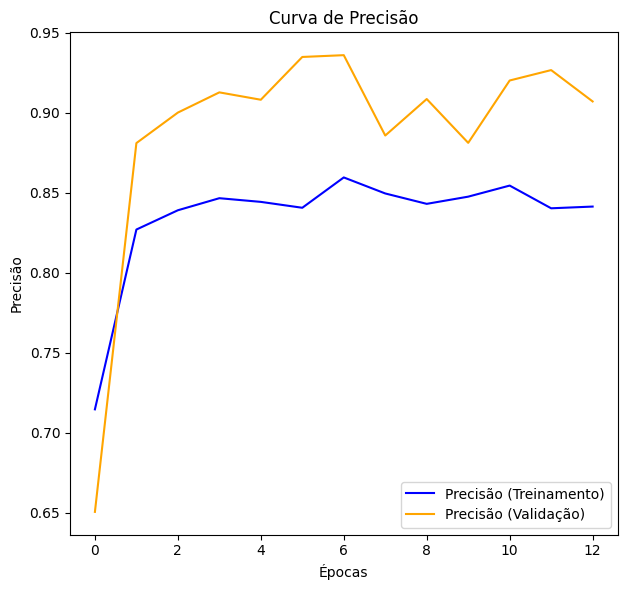

In [ ]:
# Plotar as curvas de acurácia e perda
plt.figure(figsize=(12, 6))

# Plotando a acurácia
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Acurácia (Treinamento)', color='blue')
plt.plot(history.history['val_accuracy'], label='Acurácia (Validação)', color='orange')
plt.title('Curva de Acurácia')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

# Plotar as curvas de precisão
plt.figure(figsize=(12, 6))

if 'precision' in history.history:
    plt.subplot(1, 2, 1)
    plt.plot(history.history['precision'], label='Precisão (Treinamento)', color='blue')
    plt.plot(history.history['val_precision'], label='Precisão (Validação)', color='orange')
    plt.title('Curva de Precisão')
    plt.xlabel('Épocas')
    plt.ylabel('Precisão')
    plt.legend()


# Exibir os gráficos
plt.tight_layout()
plt.show()

## **10.** Avaliação do modelo nos dados de teste

In [ ]:
# Carregar o melhor modelo salvo
best_model = load_model("/content/modelo_treinado.h5")
# Verificar a nova configuração do modelo
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)             │ (None, 10, 128, 128, 96)    │         345,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 10, 128, 128, 96)    │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 128, 128, 96)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)           │ (None, 10, 128, 128, 64)    │         655,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 10, 128, 128, 64)    │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10, 128, 128, 64)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d (Conv3D)                      │ (None, 10, 128, 128, 1)     │             577 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,002,819 (3.83 MB)

 Trainable params: 1,002,497 (3.82 MB)

 Non-trainable params: 320 (1.25 KB)

 Optimizer params: 2 (12.00 B)

In [ ]:
# Avaliar o modelo nos dados de teste
test_loss, test_accuracy, test_precision = best_model.evaluate(X_test, y_test, verbose=1)

# Realizar predições para calcular a precisão
y_pred = best_model.predict(X_test)

# Converter as predições e os rótulos para formato binário
y_pred_binary = (y_pred > 0.5).astype("int32")  # Assumindo uma saída sigmoid
y_test_binary = (y_test > 0.5).astype("int32")

# Calcular precisão - removendo esta linha, pois já está calculada na avaliação
#test_precision = precision_score(y_test_binary.flatten(), y_pred_binary.flatten())

3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.9400 - loss: 0.1747 - precision: 0.9738
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step


## **10.1** Cálculo das métricas nos dados de teste

In [ ]:
# Calcular F1-score
test_f1_score = f1_score(y_test_binary.flatten(), y_pred_binary.flatten())

# Calcular IoU (Intersection over Union)
test_iou = jaccard_score(y_test_binary.flatten(), y_pred_binary.flatten())

# Exibir os resultados
print(f'Perda no Teste: {test_loss:.4f}')
print(f'Acurácia no Teste: {test_accuracy:.4f}')
print(f'Precisão no Teste: {test_precision:.4f}') # Usando a precisão do evaluate
print(f'F1-score no Teste: {test_f1_score:.4f}')
print(f'IoU no Teste: {test_iou:.4f}')

Perda no Teste: 0.1746
Acurácia no Teste: 0.9410
Precisão no Teste: 0.9726
F1-score no Teste: 0.8576
IoU no Teste: 0.7507


Visualizando alguns patches previstos para o mês de março

In [ ]:
plt.imshow(y_test[32][2])
plt.title('Máscara Real')
plt.show()

plt.imshow(y_pred_binary[32][2])
plt.title('Máscara Prevista')
plt.show()


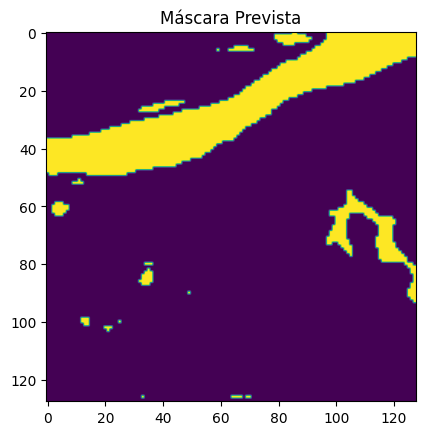

In [ ]:
plt.imshow(y_test[32][3])
plt.title('Máscara Real')
plt.show()

plt.imshow(y_pred_binary[32][3])
plt.title('Máscara Prevista')
plt.show()

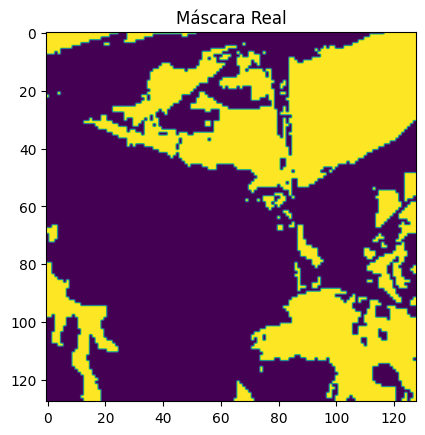

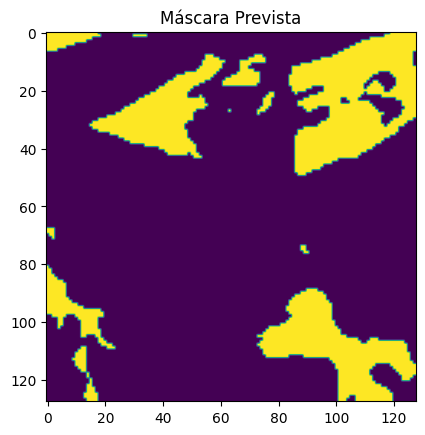

In [ ]:
plt.imshow(y_test[32][4])
plt.title('Máscara Real')
plt.show()

plt.imshow(y_pred_binary[32][4])
plt.title('Máscara Prevista')
plt.show()

Plotagem da matriz de confusão

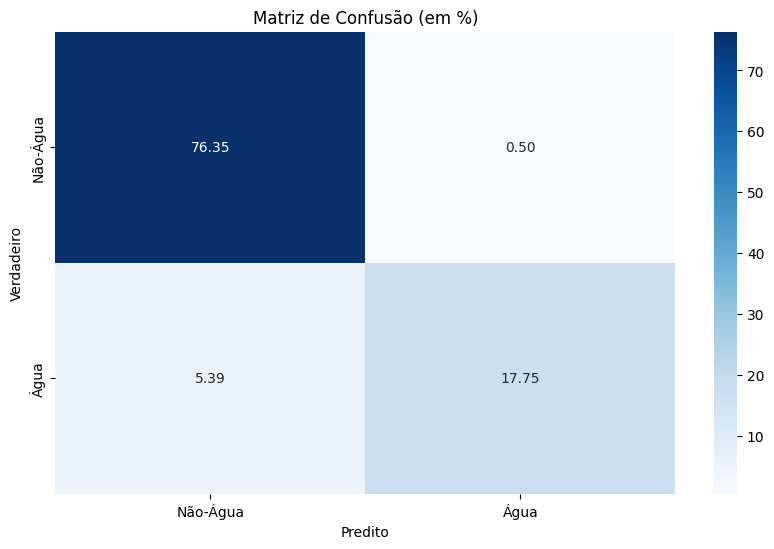

Matriz de Confusão Absoluta:
[[9007008   59055]
 [ 636363 2094054]]

Matriz de Confusão em Porcentagem:
[[76.35335286  0.50061544]
 [ 5.39451599 17.75151571]]


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calcular matriz de confusão
conf_matrix = confusion_matrix(y_test_binary.flatten(), y_pred_binary.flatten())

# Calcular matriz de confusão em porcentagens (normalizando pela soma total)
conf_matrix_percentage = conf_matrix / conf_matrix.sum() * 100  # Normalizar em porcentagem

# Visualizar a matriz de confusão
plt.figure(figsize=(10, 6))

# Matriz em porcentagens
sns.heatmap(conf_matrix_percentage, annot=True, fmt=".2f", cmap="Blues", cbar=True)
plt.title("Matriz de Confusão (em %)")
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.xticks(ticks=[0.5, 1.5], labels=["Não-Água", "Água"])
plt.yticks(ticks=[0.5, 1.5], labels=["Não-Água", "Água"])
plt.show()

# Exibir os resultados
print("Matriz de Confusão Absoluta:")
print(conf_matrix)
print("\nMatriz de Confusão em Porcentagem:")
print(conf_matrix_percentage)


## **10.2** Visualização dos patches previstos pelo modelo



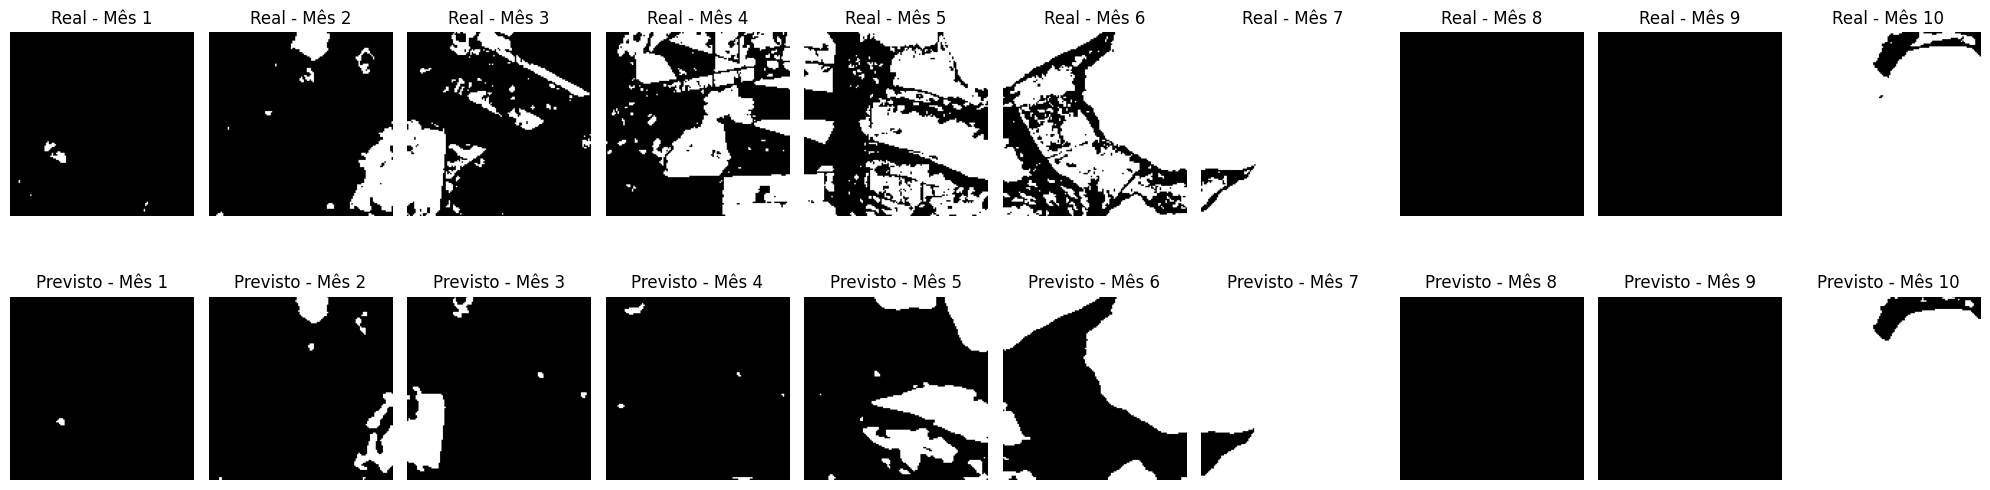

In [ ]:
# Índice do patch para visualização
patch_index = 10  # Substitua pelo índice do patch desejado

# Selecionar as máscaras reais e previstas para o patch específico
y_test_patch = y_test[patch_index]  # Dimensão: (10, 128, 128, 1)
y_pred_patch = y_pred_binary[patch_index]  # Dimensão: (10, 128, 128, 1)

# Visualizar máscaras reais e previstas para todos os meses
fig, axes = plt.subplots(2, 10, figsize=(20, 6))  # 2 linhas (real e previsto), 10 colunas (meses)

for month in range(10):
    # Máscara real
    axes[0, month].imshow(y_test_patch[month, :, :, 0], cmap='gray')
    axes[0, month].set_title(f'Real - Mês {month+1}')
    axes[0, month].axis('off')

    # Máscara prevista
    axes[1, month].imshow(y_pred_patch[month, :, :, 0], cmap='gray')
    axes[1, month].set_title(f'Previsto - Mês {month+1}')
    axes[1, month].axis('off')

# Ajustar o layout dos gráficos
plt.tight_layout()
plt.show()


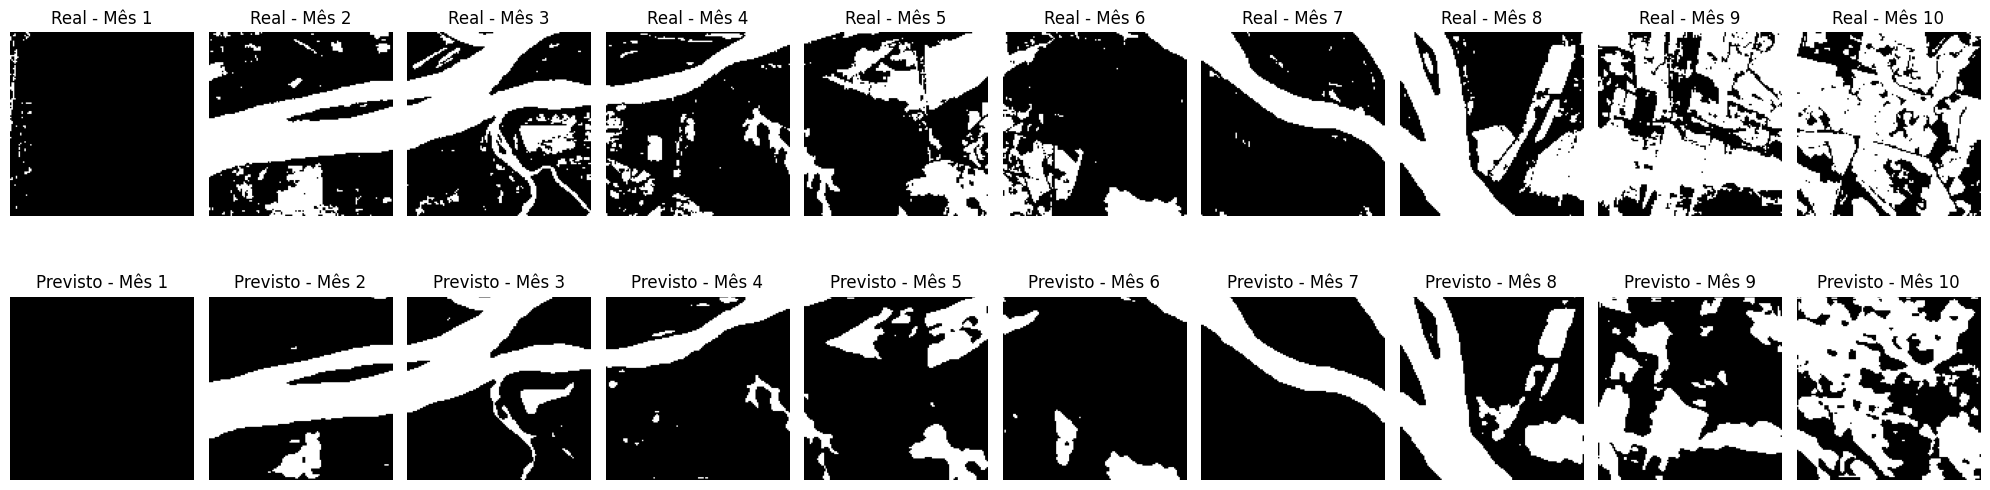

In [ ]:
# Índice do patch para visualização
patch_index = 32  # Substitua pelo índice do patch desejado

# Selecionar as máscaras reais e previstas para o patch específico
y_test_patch = y_test[patch_index]  # Dimensão: (10, 128, 128, 1)
y_pred_patch = y_pred_binary[patch_index]  # Dimensão: (10, 128, 128, 1)

# Visualizar máscaras reais e previstas para todos os meses
fig, axes = plt.subplots(2, 10, figsize=(20, 6))  # 2 linhas (real e previsto), 10 colunas (meses)

for month in range(10):
    # Máscara real
    axes[0, month].imshow(y_test_patch[month, :, :, 0], cmap='gray')
    axes[0, month].set_title(f'Real - Mês {month+1}')
    axes[0, month].axis('off')

    # Máscara prevista
    axes[1, month].imshow(y_pred_patch[month, :, :, 0], cmap='gray')
    axes[1, month].set_title(f'Previsto - Mês {month+1}')
    axes[1, month].axis('off')

# Ajustar o layout dos gráficos
plt.tight_layout()
plt.show()

## **11.** Contagem de pixels de água (1) e não-água (0) nas máscaras de referência

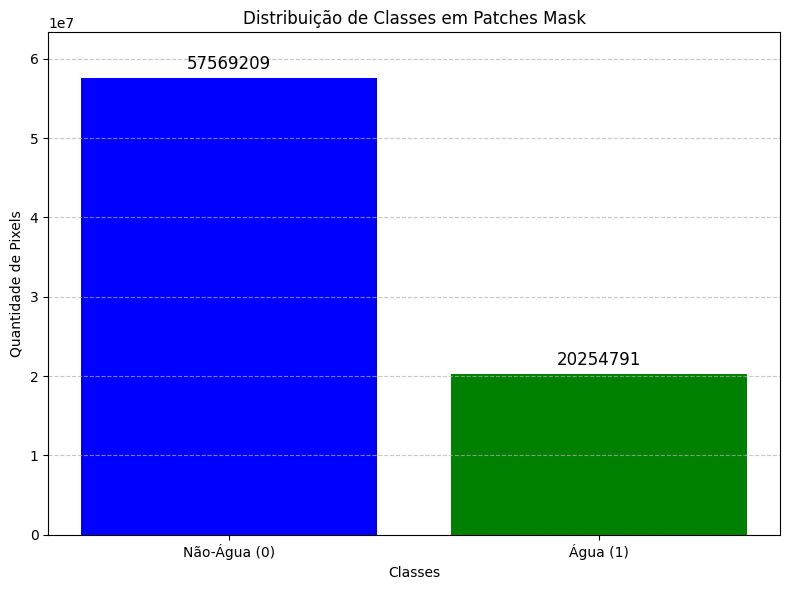

In [ ]:
# Contar a quantidade de pixels de cada classe no conjunto y = patches_mask
unique, counts = np.unique(patches_mask, return_counts=True)

# Extrair os valores para Água (1) e Não-Água (0)
classes = ['Não-Água (0)', 'Água (1)']
quantidades = [counts[0], counts[1]]  # Assume que os valores únicos são 0 e 1

# Criar o gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(classes, quantidades, color=['blue', 'green'])
plt.title('Distribuição de Classes em Patches Mask')
plt.xlabel('Classes')
plt.ylabel('Quantidade de Pixels')
plt.ylim(0, max(quantidades) * 1.1)  # Deixar espaço acima da barra mais alta para visualização
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar os valores exatos em cima das barras
for i, value in enumerate(quantidades):
    plt.text(i, value + (max(quantidades) * 0.02), str(value), ha='center', fontsize=12)

plt.tight_layout()
plt.show()


## **12.** Novo treinamento do modelo com Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Definindo o gerador de aumento de dados
def augment_data(X, y, batch_size=8):
    """
    Aplica aumento de dados tanto espacial quanto temporal.
    O aumento espacial é feito nas imagens, e o aumento temporal é feito nas sequências.

    Args:
    - X (np.array): Dados de entrada (batch, time, height, width, channels).
    - y (np.array): Máscaras de referência (batch, time, height, width, 1).
    - batch_size (int): Tamanho do batch para o gerador de dados.

    Returns:
    - Gerador que pode ser utilizado para treinamento.
    """
    datagen = ImageDataGenerator(
        rotation_range=15,  # Rotação aleatória de até 15 graus
        width_shift_range=0.1,  # Translação horizontal aleatória
        height_shift_range=0.1,  # Translação vertical aleatória
        zoom_range=0.1,  # Zoom aleatório
        horizontal_flip=True,  # Flip horizontal
        vertical_flip=True  # Flip vertical
    )

    # Aplicar o aumento de dados nas imagens de cada timestep individualmente
    def augment_batch(X_batch, y_batch):
        augmented_X = []
        augmented_y = []
        for t in range(X_batch.shape[1]):  # Iterar por cada timestep
            X_timestep = X_batch[:, t, :, :, :]  # Dados para um timestep
            y_timestep = y_batch[:, t, :, :, :]  # Máscaras para um timestep

            # Aumentar espacialmente as imagens de cada timestep
            augmented_X_timestep = datagen.flow(X_timestep, batch_size=X_batch.shape[0], shuffle=False)
            augmented_y_timestep = datagen.flow(y_timestep, batch_size=X_batch.shape[0], shuffle=False)

            augmented_X.append(augmented_X_timestep[0])  # Pegar o primeiro batch
            augmented_y.append(augmented_y_timestep[0])  # Pegar o primeiro batch

        augmented_X = np.stack(augmented_X, axis=1)
        augmented_y = np.stack(augmented_y, axis=1)

        return augmented_X, augmented_y

    # Gerador de dados que aplica o aumento de dados
    while True:
        for i in range(0, X.shape[0], batch_size):
            X_batch = X[i:i+batch_size]
            y_batch = y[i:i+batch_size]
            augmented_X, augmented_y = augment_batch(X_batch, y_batch)
            yield augmented_X, augmented_y



In [ ]:
from tensorflow.keras.losses import binary_crossentropy
# Criando o gerador de aumento de dados
train_generator = augment_data(X_train, y_train, batch_size=8)

# Recompilar o modelo com a perda ponderada (mantendo o melhor modelo encontrado pelo Keras-Tuner)
best_model.compile(optimizer=Adam(learning_rate=0.001),
                   loss= binary_crossentropy,
                   metrics=['accuracy', Precision()])

# Re-treinar o modelo com aumento de dados
history_augmented = best_model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 8,  # Número de batches por época
    epochs=15,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

# Salvar o modelo treinado
best_model.save('modelo_treinado_com_augmentacao.h5')


Epoch 1/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.7610 - loss: 0.4755 - precision: 0.7548 - val_accuracy: 0.8807 - val_loss: 0.3217 - val_precision: 0.8830
Epoch 2/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.7615 - loss: 0.4685 - precision: 0.7700 - val_accuracy: 0.8802 - val_loss: 0.3462 - val_precision: 0.9043
Epoch 3/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.7794 - loss: 0.4428 - precision: 0.7842 - val_accuracy: 0.8819 - val_loss: 0.3270 - val_precision: 0.9339
Epoch 4/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.7879 - loss: 0.4311 - precision: 0.7847 - val_accuracy: 0.8826 - val_loss: 0.3255 - val_precision: 0.9100
Epoch 5/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.7673 - loss: 0.4604 - precision: 0.8026 - val_accuracy: 0.8829 - val_loss: 0.3213 - val_precision: 0.8933


## **12.1** Avaliação do modelo com Data Augmentation nos dados de teste


In [ ]:
# Avaliar o modelo treinado
test_loss, test_accuracy, test_precision = best_model.evaluate(X_test, y_test, verbose=1)

print(f'Perda no Teste (ajustada): {test_loss:.4f}')
print(f'Acurácia no Teste (ajustada): {test_accuracy:.4f}')
print(f'Precisão no Teste (ajustada): {test_precision:.4f}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.8711 - loss: 0.3402 - precision: 0.9058
Perda no Teste (ajustada): 0.3265
Acurácia no Teste (ajustada): 0.8789
Precisão no Teste (ajustada): 0.9048


In [ ]:
# Fazer as predições para o conjunto de teste
y_pred = best_model.predict(X_test)

# Converter as predições e os rótulos para formato binário (threshold de 0.5 para sigmoid)
y_pred_binary = (y_pred > 0.5).astype("int32")
y_test_binary = (y_test > 0.5).astype("int32")

# Cálculo do F1-score
test_f1_score = f1_score(y_test_binary.flatten(), y_pred_binary.flatten())
print(f'F1-score no Teste: {test_f1_score:.4f}')

# Cálculo do IoU (Intersection over Union)
test_iou = jaccard_score(y_test_binary.flatten(), y_pred_binary.flatten())
print(f'IoU no Teste: {test_iou:.4f}')

# Cálculo da matriz de confusão
conf_matrix = confusion_matrix(y_test_binary.flatten(), y_pred_binary.flatten())

# Normalizando a matriz de confusão para porcentagem
conf_matrix_percentage = conf_matrix / conf_matrix.sum() * 100

# Exibindo a matriz de confusão em porcentagem
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix_percentage, annot=True, fmt=".2f", cmap="Blues", cbar=True)
plt.title("Matriz de Confusão (em %)")
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.xticks(ticks=[0.5, 1.5], labels=["Não-Água", "Água"])
plt.yticks(ticks=[0.5, 1.5], labels=["Não-Água", "Água"])
plt.show()

2/3 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step
F1-score no Teste: 0.7459
IoU no Teste: 0.5948


In [ ]:
# Parâmetros
patch_idx = 69  # Índice do patch
selected_months = [0,1,2,3,4,5, 6, 7,8,9]  # Meses selecionados (índices começam em 0)

# Verificar se o índice está dentro do limite
if patch_idx >= y_pred_binary.shape[0]:
    raise IndexError(f"O índice do patch ({patch_idx}) excede o número de amostras ({y_pred_binary.shape[0]}).")

# Selecionar as predições e a máscara de referência para o índice do patch e meses selecionados
predicted_patches = y_pred_binary[patch_idx, selected_months, :, :, 0]  # Dimensão: (len(selected_months), height, width)
reference_patches = y_test_binary[patch_idx, selected_months, :, :, 0]  # Dimensão: (len(selected_months), height, width)

# Configurar o layout do plot: duas linhas, uma para predições e outra para referências
fig, axes = plt.subplots(2, len(selected_months), figsize=(15, 8))

# Título geral
fig.suptitle(f"Comparação para o Patch {patch_idx} nos Meses {', '.join(map(str, [m + 1 for m in selected_months]))}", fontsize=16)

# Linha 1: Máscaras de referência (uma para cada mês selecionado)
for i, month in enumerate(selected_months):
    axes[0, i].imshow(reference_patches[i], cmap='gray')
    axes[0, i].set_title(f"Referência {month + 1}")
    axes[0, i].axis('off')

# Linha 2: Predições (uma para cada mês selecionado)
for i, month in enumerate(selected_months):
    axes[1, i].imshow(predicted_patches[i], cmap='gray')
    axes[1, i].set_title(f"Predição - Mês {month + 1}")
    axes[1, i].axis('off')

# Ajustar layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Reservar espaço para o título geral
plt.show()
